## Necessary Imports and paths

In [2]:
!pip install opencv-python pywavelets
!pip install tqdm
!pip install scikit-image
!pip install h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 2.0 MB/s eta 0:00:00a 0:00:01


In [58]:
import os
import cv2
import numpy as np
import pywt
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.restoration import denoise_wavelet, estimate_sigma
from skimage import img_as_float
from scipy import fftpack
import h5py


In [59]:
input_path = 'DIP Data'
noise_path = 'noise_data.h5'

## Finding minimum resolution some necessary functions

In [ ]:
min_width, min_height = float('inf'), float('inf')

for folder in os.listdir(input_path):
    folder_path = os.path.join(input_path, folder)
    image_files = os.listdir(folder_path)
    for img_file in tqdm(image_files, desc=f"Processing {folder}"):
        img_path = os.path.join(folder_path, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        h, w = img.shape
        min_width = min(min_width, w)
        min_height = min(min_height, h)

x, y = min_width, min_height
print(f"\nMinimum resolution for cropping: width={x}, height={y}")

Processing Sony_DSC_W170: 100%|██████████| 300/300 [02:38<00:00,  1.90it/s]


Minimum resolution for cropping: width=2000, height=2000


Saving it as x and y

In [60]:
x = 2000
y = 2000

This fucntion uses the extract_noise function defined through various methods discussed below.
and saves it in compact readale HDF5 binary data format

In [56]:
def save_noise(input_path, filename="noise_data.h5", compression="gzip"):
    with h5py.File(filename, "w") as f:
        for folder in os.listdir(input_path):
            folder_path = os.path.join(input_path, folder)
            if not os.path.isdir(folder_path):
                continue
            f_name = folder.split('_')[0]
            image_files = sorted([f for f in os.listdir(folder_path)])
            group = f.create_group(f_name)
            print(len(image_files))
            # Process each image
            for idx, img_file in enumerate(tqdm(image_files, desc=f"Processing {folder}"), 1):
                img_path = os.path.join(folder_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                cropped = img[:512, :512]
                noise = extract_noise(cropped)
                if noise is None:
                    continue
                group.create_dataset(f"array_{idx}", data=noise, compression=compression)
    
    print(f"Saved noise arrays to {filename}")

This reads  ```the noise_data.h5``` and computes the target noise or SPN (Sensor Pattern Noise), which is used to calculate the correlation the noise of the test image.

this fucntion uses a parameter n which is defined for how many noises are to be averaged to obtain the SPN.


In [ ]:
def target_noise(n):
    print(f'Generating Sensor Pattern Noise using: {n} noises')
    target_noises = {}
    
    with h5py.File("noise_data.h5", "r") as f:
        brands = list(f.keys())
        print(f"Found brands: {brands}")
        
        for brand in brands:
            group = f[brand]
            array_keys = sorted(group.keys())
            noise_accumulator = None
            arrays_used = 0
            
            for key in tqdm(array_keys[:n], desc=f"Averaging {brand}"):
                try:
                    noise = group[key][:]
                    if noise_accumulator is None:
                        noise_accumulator = np.zeros_like(noise, dtype=np.float64)
                    noise_accumulator += noise
                    arrays_used += 1
                except KeyError:
                    print(f"Error: Could not find {key} in {brand}. Skipping.")
                    continue
            
            if arrays_used == 0:
                print(f"Error: No valid arrays found for {brand}. Skipping.")
                continue
            
            avg_noise = (noise_accumulator / arrays_used).astype(np.float64)
            target_noises[brand] = avg_noise
            print(f"Processed {brand}: Averaged {arrays_used} arrays")
    
    print("Done")
    return target_noises

In [ ]:
def pearson_correlation(X, Y):
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)

    X_mean = np.mean(X)
    Y_mean = np.mean(Y)

    X_zero_mean = X - X_mean
    Y_zero_mean = Y - Y_mean

    numerator = np.sum(X_zero_mean * Y_zero_mean)
    denominator = np.sqrt(np.sum(X_zero_mean ** 2)) * np.sqrt(np.sum(Y_zero_mean ** 2))

    return numerator / (denominator + 1e-8)

This fucntion is used to compute the correlations of all the test image (last 100 images from all cameras) with all 7 SPNs obtained in a final_dict.
```
final_dict = {
'Camera1':{'Camera1':[correlations],
           'Camera2':[correlations]...}, 
'Camera2':{'Camera1':[correlations], 
           'Camera2':[correlations]...}
           ...
}
```

Useluf for plotting

In [71]:
def compute_correlations(target_noises, hdf5_file="noise_data.h5"):
    final_dict = {}
    
    with h5py.File(hdf5_file, "r") as f:
        for target, target_spn in target_noises.items():
            correlation_dict = {}
            print(f"\nCalculating correlation for target: {target}")
            
            for camera_dir in f.keys():
                correlation_dict[camera_dir] = []
                group = f[camera_dir]
                array_keys = sorted(group.keys())
            
                for key in tqdm(array_keys[200:], desc=f"Processing {camera_dir}"):
                    noise = group[key][:] 
                    corr = pearson_correlation(noise, target_spn)
                    correlation_dict[camera_dir].append(corr)
                
                if not correlation_dict[camera_dir]:
                    print(f"Warning: No correlations computed for {camera_dir}.")
            
            final_dict[target] = correlation_dict
    
    print("Correlation computation completed")
    return final_dict

Function to compute the accuracy

In [84]:
def compute_accuracy(target_noises):
    accuracy_dict = {}
    with h5py.File("noise_data.h5", "r") as f:
        brands = sorted(f.keys())
        print(f"Brands: {brands}")
        
        for actual_brand in brands:
            group = f[actual_brand]
            array_keys = sorted(group.keys())
            test_keys = array_keys[200:]
            correct_matches = 0
            
            print(len(test_keys))
            print(f"\nProcessing test arrays for {actual_brand}")
            for key in tqdm(test_keys, desc=f"Testing {actual_brand}"):
                noise = group[key][:]
                correlations = {}
                for target_brand, target_spn in target_noises.items():
                    corr = pearson_correlation(noise, target_spn)
                    correlations[target_brand] = corr

                predicted_brand = max(correlations, key=correlations.get)                    
                if predicted_brand == actual_brand:
                    correct_matches += 1
            
            accuracy = correct_matches
            accuracy_dict[actual_brand] = accuracy
            print(f"{actual_brand}: {correct_matches}/100 correct, Accuracy = {accuracy:.4f}")
    
    print("Accuracy computation completed")
    return accuracy_dict

## Using builtin functions of scikit-image 

Using the ```denoise_wavelet()``` function to generate denoised images.

```
denoised_image = denoise_wavelet(
        noisy_image,
        method='VisuShrink',
        mode='soft',
        sigma=sigma_est,
        wavelet=wavelet,
        wavelet_levels=level,
        rescale_sigma=True
    )
```

subtracting it to  obtain the noise

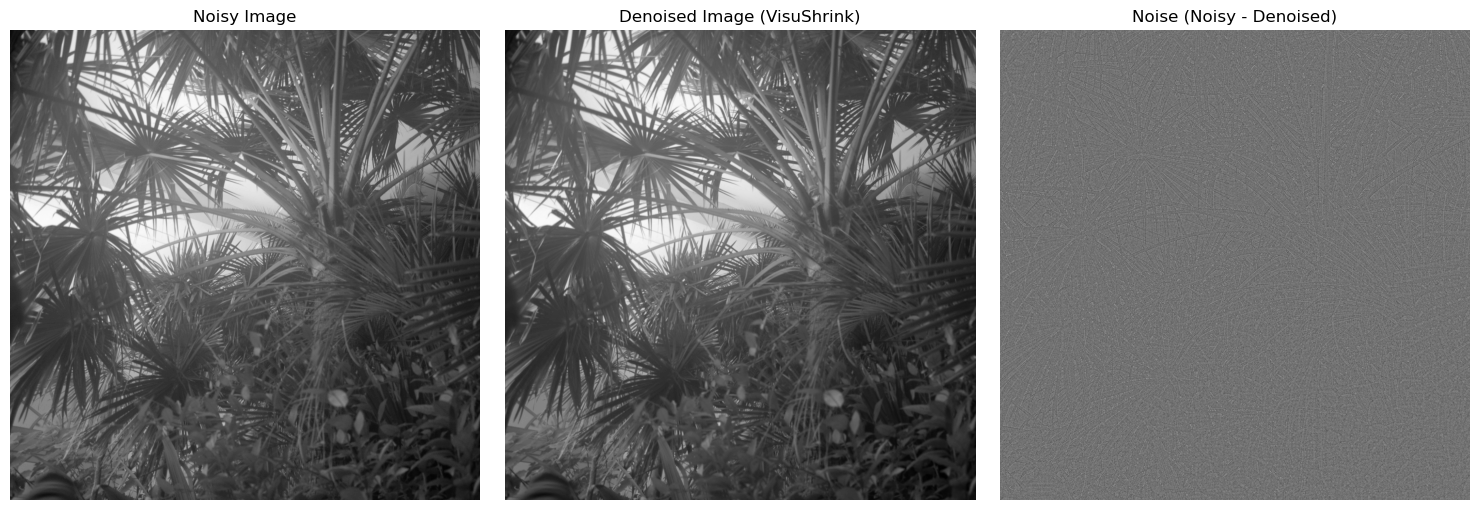

In [61]:
def denoise_image_skimage(image_path, wavelet='db8', level=5):
    noisy_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(float)
    noisy_image = noisy_image[:y, :x]
    if noisy_image is None:
        raise ValueError(f"Image not found: {image_path}")
    
    sigma_est = estimate_sigma(noisy_image, average_sigmas=True)
    
    denoised_image = denoise_wavelet(
        noisy_image,
        method='VisuShrink',
        mode='soft',
        sigma=sigma_est,
        wavelet=wavelet,
        wavelet_levels=level,
        rescale_sigma=True
    )
    
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    denoised_image = np.clip(denoised_image, 0, 255).astype(np.uint8)
    noise = noisy_image.astype(float) - denoised_image.astype(float)
    
    return noisy_image, denoised_image, noise

def plot_images(noisy_image, denoised_image, noise):

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(noisy_image, cmap='gray')
    axes[0].set_title('Noisy Image')
    axes[0].axis('off')
    
    axes[1].imshow(denoised_image, cmap='gray')
    axes[1].set_title(f'Denoised Image (VisuShrink)')
    axes[1].axis('off')
    
    axes[2].imshow(noise, cmap='gray')
    axes[2].set_title('Noise (Noisy - Denoised)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig('denoising_results_skimage.png')
    plt.show()

image_path = 'DIP Data/Nikon_D70/Nikon_D70_0_19535.JPG'
noisy_image, denoised_image, sigma_est = denoise_image_skimage(image_path)
plot_images(noisy_image, denoised_image, sigma_est)

Explicitly defining extract noise for end to end pipeline and for being used in ```save_noise()```

In [55]:
def extract_noise(noisy_image, wavelet='db8', level=5):
    sigma_est = estimate_sigma(noisy_image, average_sigmas=True)
    denoised_image = denoise_wavelet(
        noisy_image,
        method='VisuShrink',
        mode='soft',
        sigma=sigma_est,
        wavelet=wavelet,
        wavelet_levels=level,
        rescale_sigma=True
    )
    
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    denoised_image = np.clip(denoised_image, 0, 255).astype(np.uint8)
    noise = np.clip(noisy_image.astype(float) - denoised_image.astype(float), 0, 255)
    
    return noise

In [ ]:
save_noise(input_path, filename="noise_data.h5", compression="gzip")

300


Processing Canon_Ixus70_0:   0%|          | 0/300 [00:00<?, ?it/s]

Processing Canon_Ixus70_0: 100%|██████████| 300/300 [03:57<00:00,  1.26it/s]


300


Processing Casio_EX_Z150_0: 100%|██████████| 300/300 [04:48<00:00,  1.04it/s]


300


Processing FujiFilm_FinePixJ50_0: 100%|██████████| 300/300 [03:47<00:00,  1.32it/s]


300


Processing Nikon_D70: 100%|██████████| 300/300 [01:53<00:00,  2.64it/s]


300


Processing Olympus_mju_1050SW: 100%|██████████| 300/300 [04:45<00:00,  1.05it/s]


300


Processing Panasonic_DMC_FZ50: 100%|██████████| 300/300 [04:39<00:00,  1.07it/s]


300


Processing Sony_DSC_W170: 100%|██████████| 300/300 [04:14<00:00,  1.18it/s]

Saved noise arrays to noise_data.h5


In [ ]:
target_noises = target_noise(100)

In [ ]:
final_dict = compute_correlations(target_noises)


Calculating correlation for target: Canon


Processing Sony: 100%|██████████| 100/100 [00:07<00:00, 14.01it/s]



Calculating correlation for target: Casio


Processing Sony: 100%|██████████| 100/100 [00:06<00:00, 16.42it/s]



Calculating correlation for target: FujiFilm


Processing Sony: 100%|██████████| 100/100 [00:07<00:00, 14.19it/s]



Calculating correlation for target: Nikon


Processing Sony: 100%|██████████| 100/100 [00:05<00:00, 17.52it/s]



Calculating correlation for target: Olympus


Processing Sony: 100%|██████████| 100/100 [00:06<00:00, 14.66it/s]



Calculating correlation for target: Panasonic


Processing Sony: 100%|██████████| 100/100 [00:07<00:00, 13.87it/s]



Calculating correlation for target: Sony


Processing Sony: 100%|██████████| 100/100 [00:06<00:00, 15.70it/s]

Correlation computation completed


/tmp/ipykernel_267354/451534584.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(camera_list))  # Unique color per camera


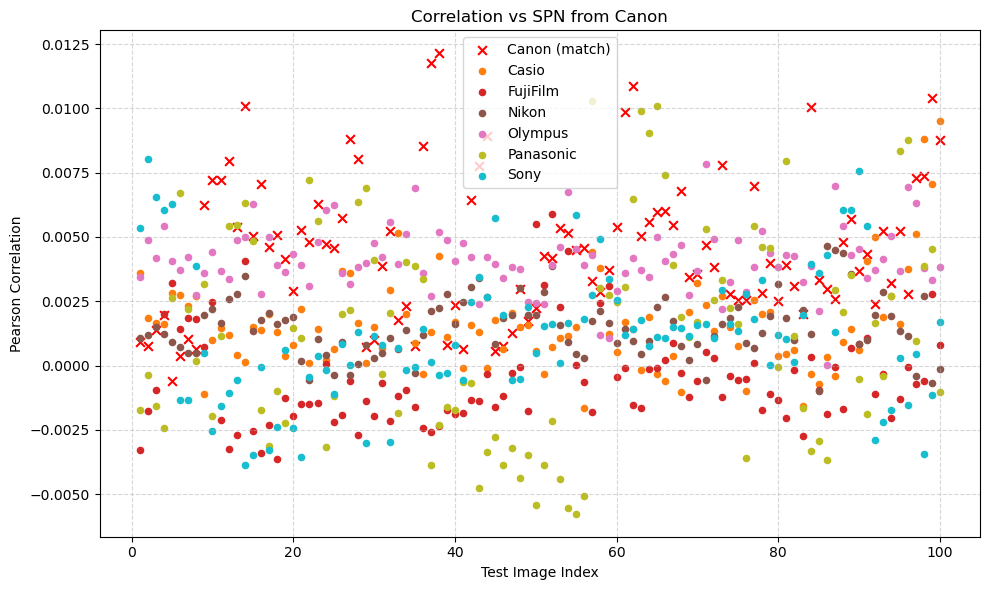

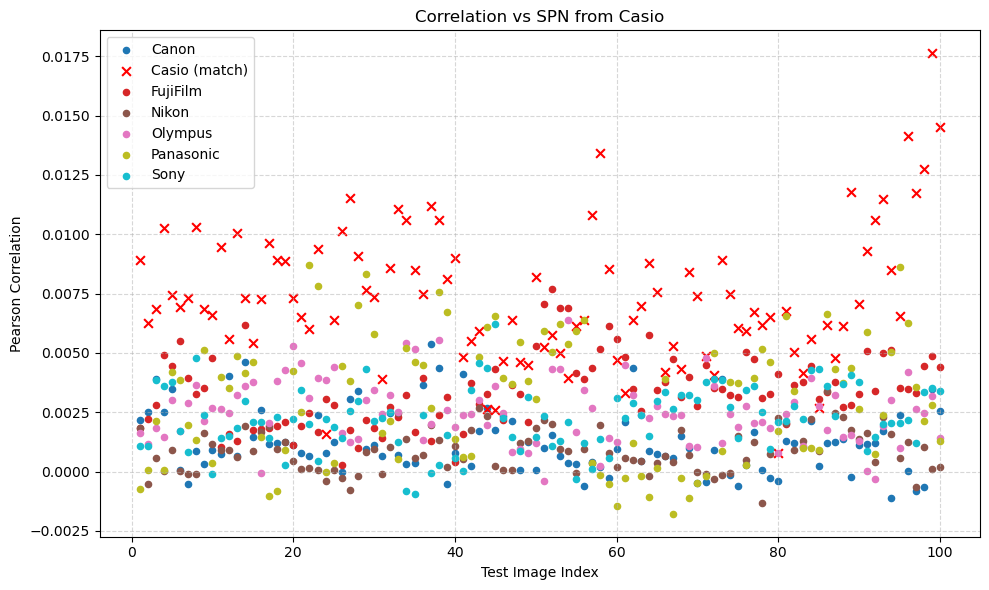

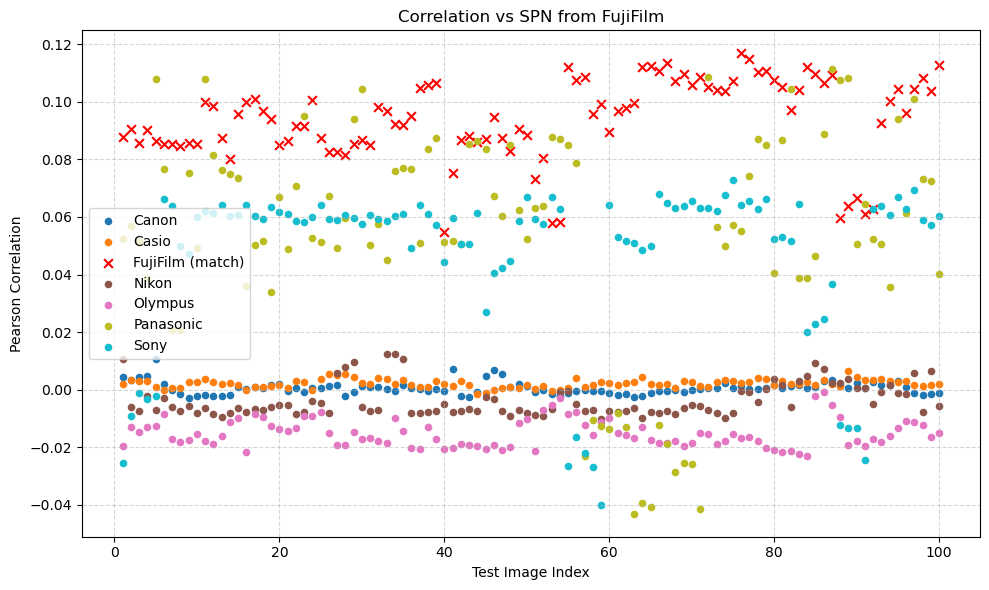

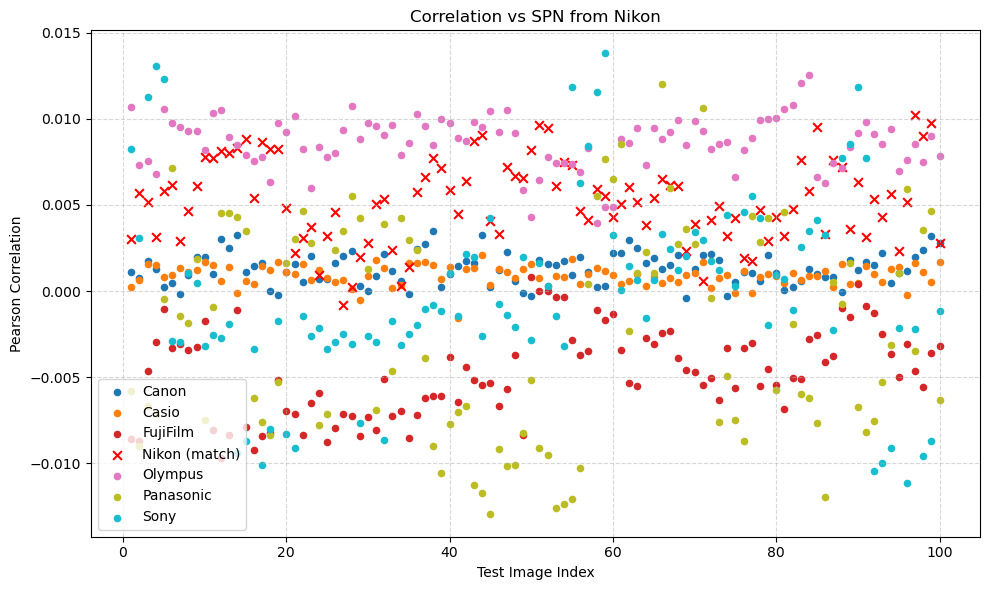

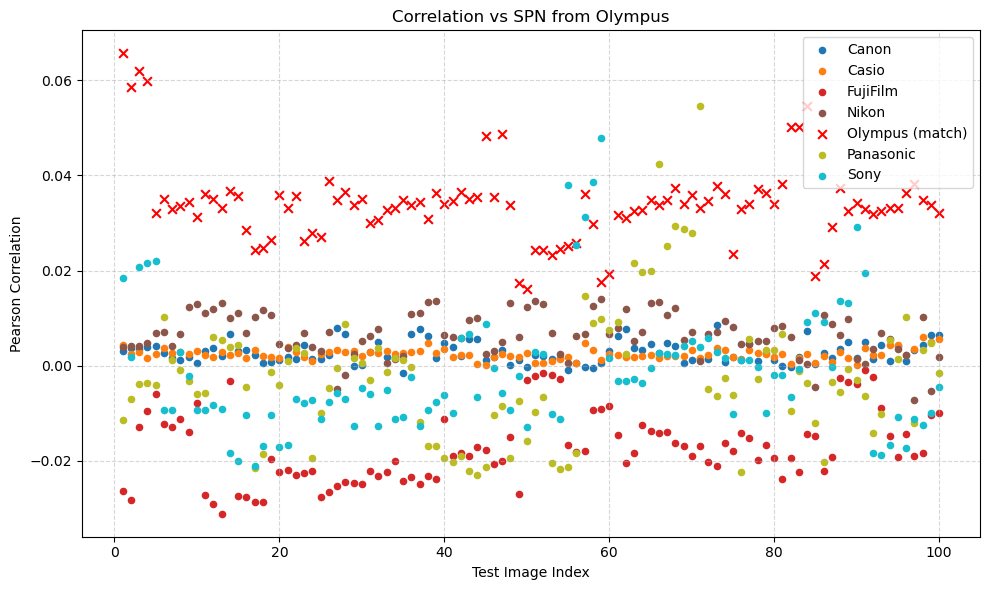

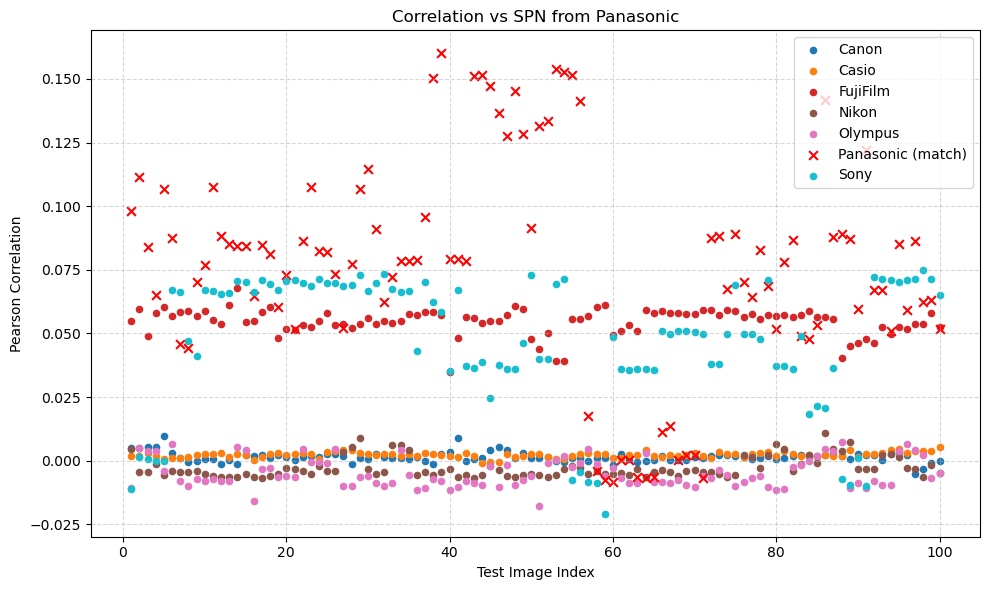

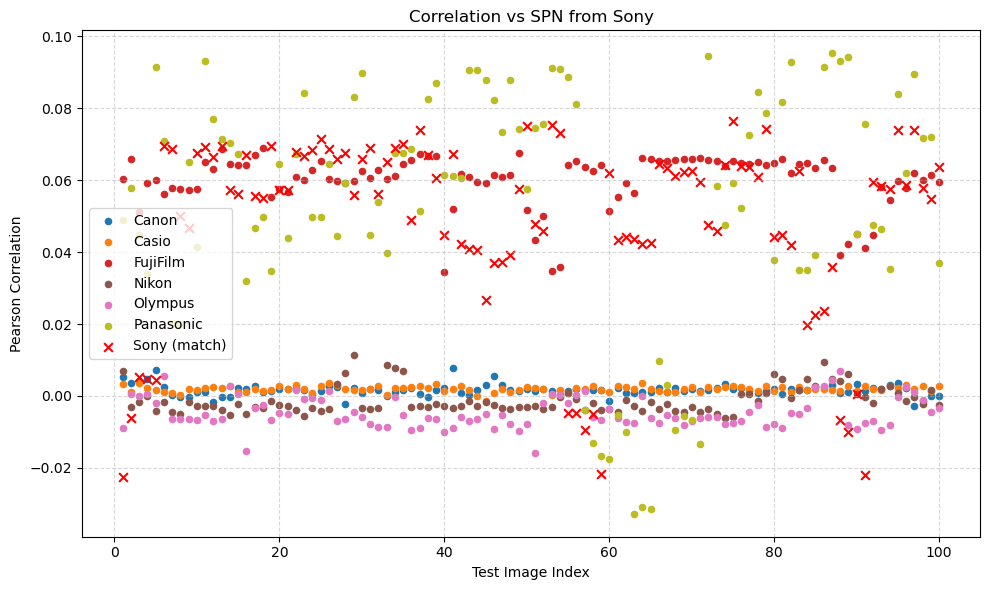

In [ ]:
camera_list = sorted(next(iter(final_dict.values())).keys()) 
colors = cm.get_cmap('tab10', len(camera_list))
for idx, (target_cam, corr_dict) in enumerate(final_dict.items()):
    plt.figure(figsize=(10, 6))
    plt.title(f'Correlation vs SPN from {target_cam}')
    plt.xlabel("Test Image Index")
    plt.ylabel("Pearson Correlation")

    for cam_idx, camera in enumerate(camera_list):
        y = corr_dict[camera]
        x = list(range(1, len(y) + 1))

        if camera == target_cam:
            plt.scatter(x, y, label=f"{camera} (match)", color='red', marker='x', s=40, linewidths=1.5)
        else:
            plt.scatter(x, y, label=camera, color=colors(cam_idx), marker='o', s=20)

    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

## Using method given in paper

Denoising using the given refernece 

M. K. Mihcak, I. Kozintsev, K. Ramchandran, and P. Moulin, “Low-complexity image denoising based on 
statistical modeling of wavelet coefficients,” IEEE Signal Processing Letters, vol. 6, no. 12, pp. 300–303, 
1999. 

There are alot of fucntions the main one is ```denoise_image()``` which is using other fucntions to obtain the parameters to duccessfully and precisely imlement the method mentioned in the above paper.

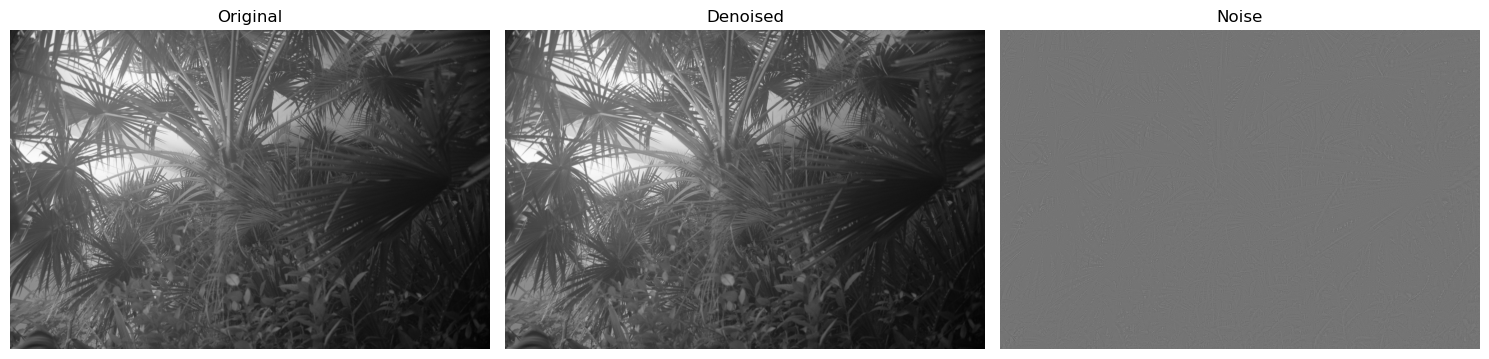

In [65]:
def estimate_noise(img):
    coeffs = pywt.wavedec2(img, 'db1', level=1)
    detail_coeffs = coeffs[1][2]
    mad = np.median(np.abs(detail_coeffs))
    sigma = mad / 0.6745    
    return sigma

def estimate_prior_lambda(denoised_coeffs, level_idx, orient_idx):
    flat_coeffs = np.abs(denoised_coeffs[level_idx][orient_idx]).flatten()
    flat_coeffs = flat_coeffs[flat_coeffs > 0]
    if len(flat_coeffs) == 0:
        return 1.0
    lambda_param = 1.0 / np.std(flat_coeffs)
    lambda_param = max(0.1, min(lambda_param, 10.0))
    return lambda_param


def estimate_variances(subband, noise_variance, window_size, lambda_param):
    window = np.ones((window_size, window_size)) / (window_size * window_size)
    squared_subband = subband ** 2
    local_means = np.sqrt(np.abs(np_correlate2d(squared_subband, window, mode='same')))
    ml_variances = local_means - noise_variance
    ml_variances = np.maximum(ml_variances, 0)
    window_size_sq = window_size ** 2
    map_variances = np.zeros_like(ml_variances)
    positive_indices = ml_variances > 0
    map_variances[positive_indices] = (ml_variances[positive_indices] * window_size_sq) / \
                                      (window_size_sq + noise_variance * lambda_param)
    
    return map_variances


def np_correlate2d(x, kernel, mode='same'):
    x_shape = np.array(x.shape)
    kernel_shape = np.array(kernel.shape)
    
    if mode == 'same':
        shape = x_shape
    else:
        shape = x_shape + kernel_shape - 1
    
    fshape = [fft_next_fast_len(int(d)) for d in shape]
    fslice = tuple([slice(0, int(sz)) for sz in shape])
    
    x_pad = np.zeros(fshape, dtype=complex)
    k_pad = np.zeros(fshape, dtype=complex)
    
    x_pad[:x.shape[0], :x.shape[1]] = x
    k_pad[:kernel.shape[0], :kernel.shape[1]] = kernel
    
    X = np.fft.fft2(x_pad)
    K = np.fft.fft2(k_pad)
    result = np.fft.ifft2(X * np.conj(K))
    result = result.real[fslice]
    
    return result


def fft_next_fast_len(n):
    return 2 ** int(np.ceil(np.log2(n)))


def denoise_wavelet_coeffs(coeffs, noise_variance, window_size):
    denoised_coeffs = [c.copy() if isinstance(c, np.ndarray) else 
                      [s.copy() for s in c] for c in coeffs]
    rough_denoised = [c.copy() if isinstance(c, np.ndarray) else 
                     [s.copy() for s in c] for c in coeffs]
    
    threshold = np.sqrt(2 * noise_variance * np.log(len(coeffs)))
    for i in range(1, len(rough_denoised)):
        for j in range(len(rough_denoised[i])):
            rough_denoised[i][j] = pywt.threshold(rough_denoised[i][j], threshold, 'soft')
    
    for i in range(1, len(coeffs)):
        for j in range(len(coeffs[i])):
            lambda_param = estimate_prior_lambda(rough_denoised, i, j)            
            subband = coeffs[i][j]            
            estimated_variances = estimate_variances(subband, noise_variance, window_size, lambda_param)            
            shrinkage_factors = estimated_variances / (estimated_variances + noise_variance)
            denoised_coeffs[i][j] = subband * shrinkage_factors
    
    return denoised_coeffs


def denoise_image(noisy_image, noise_sigma, window_size=7, wavelet='db8', level=5):

    noise_variance = noise_sigma ** 2    
    coeffs = pywt.wavedec2(noisy_image, wavelet, level=level)        
    denoised_coeffs = denoise_wavelet_coeffs(coeffs, noise_variance, window_size)        
    denoised_image = pywt.waverec2(denoised_coeffs, wavelet)    
    denoised_image = np.clip(denoised_image, 0, 1)
    return denoised_image


def main():
    image = cv2.imread('DIP Data/Nikon_D70/Nikon_D70_0_19535.JPG',  cv2.IMREAD_GRAYSCALE)
    image = img_as_float(image)
    noise_sigma = estimate_noise(image)
    denoised_image = denoise_image(image, noise_sigma, window_size=7)

    noise = image - denoised_image
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(image, cmap='gray')
    plt.title(f'Original')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(denoised_image, cmap='gray')
    plt.title(f'Denoised')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(noise, cmap='gray')
    plt.title(f'Noise')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

In [66]:
def extract_noise(noisy_image, window_size=7, wavelet='db8', level=5):
    noise_sigma = estimate_noise(noisy_image)
    noise_variance = noise_sigma ** 2
        
    coeffs = pywt.wavedec2(noisy_image, wavelet, level=level)    
    denoised_coeffs = denoise_wavelet_coeffs(coeffs, noise_variance, window_size)    
    denoised_image = pywt.waverec2(denoised_coeffs, wavelet)
    
    denoised_image = np.clip(denoised_image, 0, 1)
    noise = noisy_image - denoised_image
    
    return noise

In [ ]:
save_noise(input_path, filename="noise_data.h5", compression="gzip")

300


Processing Canon_Ixus70_0:   0%|          | 0/300 [00:00<?, ?it/s]

Processing Canon_Ixus70_0: 100%|██████████| 300/300 [03:57<00:00,  1.26it/s]


300


Processing Casio_EX_Z150_0: 100%|██████████| 300/300 [04:48<00:00,  1.04it/s]


300


Processing FujiFilm_FinePixJ50_0: 100%|██████████| 300/300 [03:47<00:00,  1.32it/s]


300


Processing Nikon_D70: 100%|██████████| 300/300 [01:53<00:00,  2.64it/s]


300


Processing Olympus_mju_1050SW: 100%|██████████| 300/300 [04:45<00:00,  1.05it/s]


300


Processing Panasonic_DMC_FZ50: 100%|██████████| 300/300 [04:39<00:00,  1.07it/s]


300


Processing Sony_DSC_W170: 100%|██████████| 300/300 [04:14<00:00,  1.18it/s]

Saved noise arrays to noise_data.h5


In [ ]:
target_noises = target_noise(100)

In [ ]:
final_dict = compute_correlations(target_noises)


Calculating correlation for target: Canon


Processing Sony: 100%|██████████| 100/100 [00:07<00:00, 14.01it/s]



Calculating correlation for target: Casio


Processing Sony: 100%|██████████| 100/100 [00:06<00:00, 16.42it/s]



Calculating correlation for target: FujiFilm


Processing Sony: 100%|██████████| 100/100 [00:07<00:00, 14.19it/s]



Calculating correlation for target: Nikon


Processing Sony: 100%|██████████| 100/100 [00:05<00:00, 17.52it/s]



Calculating correlation for target: Olympus


Processing Sony: 100%|██████████| 100/100 [00:06<00:00, 14.66it/s]



Calculating correlation for target: Panasonic


Processing Sony: 100%|██████████| 100/100 [00:07<00:00, 13.87it/s]



Calculating correlation for target: Sony


Processing Sony: 100%|██████████| 100/100 [00:06<00:00, 15.70it/s]

Correlation computation completed


/tmp/ipykernel_267354/451534584.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(camera_list))  # Unique color per camera


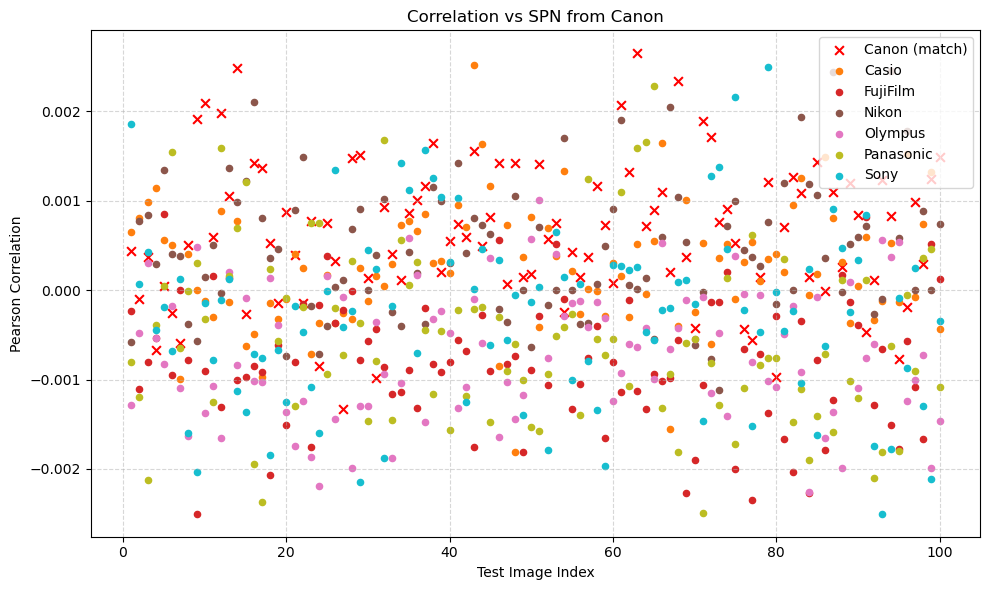

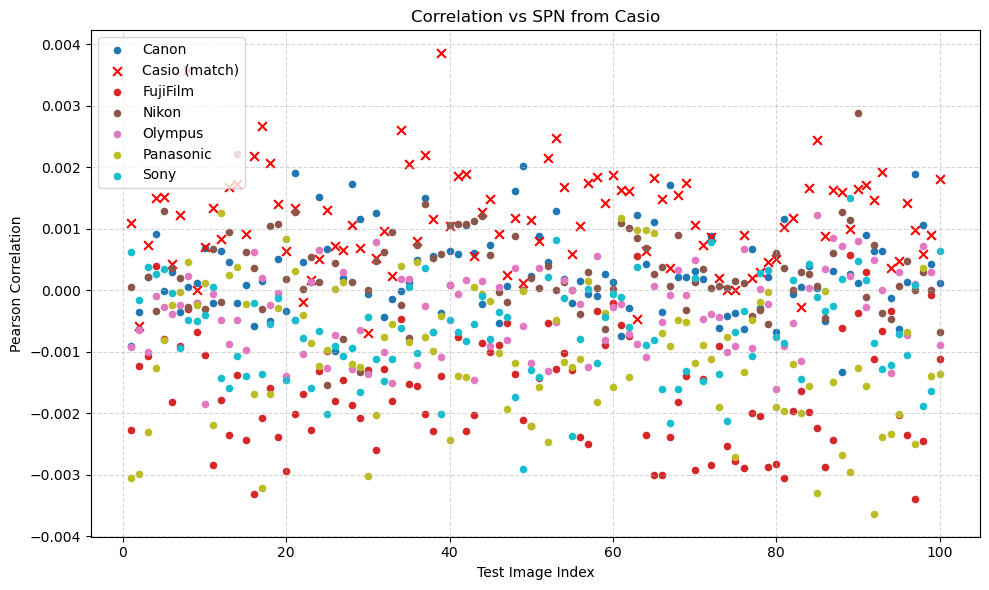

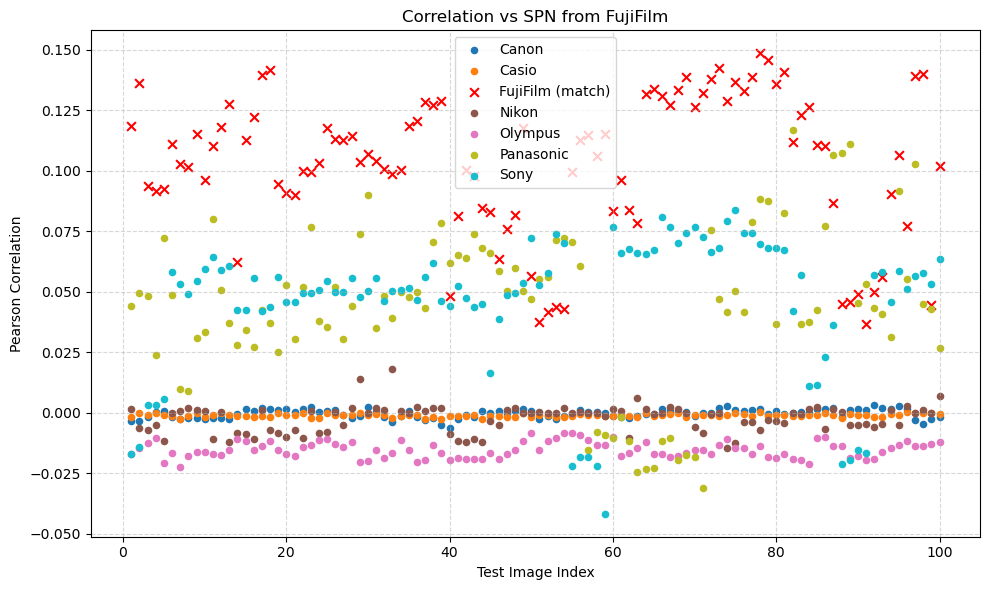

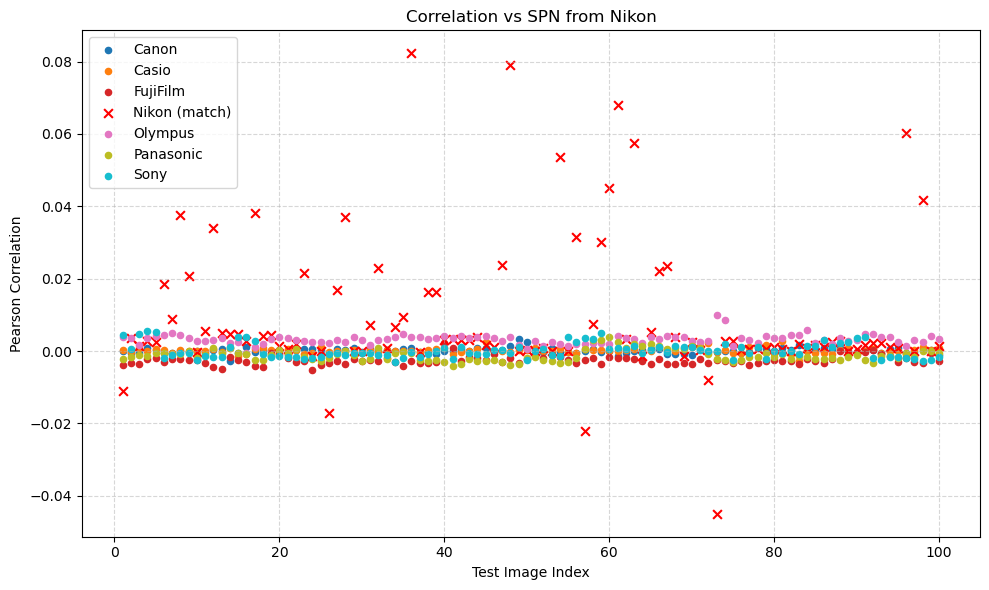

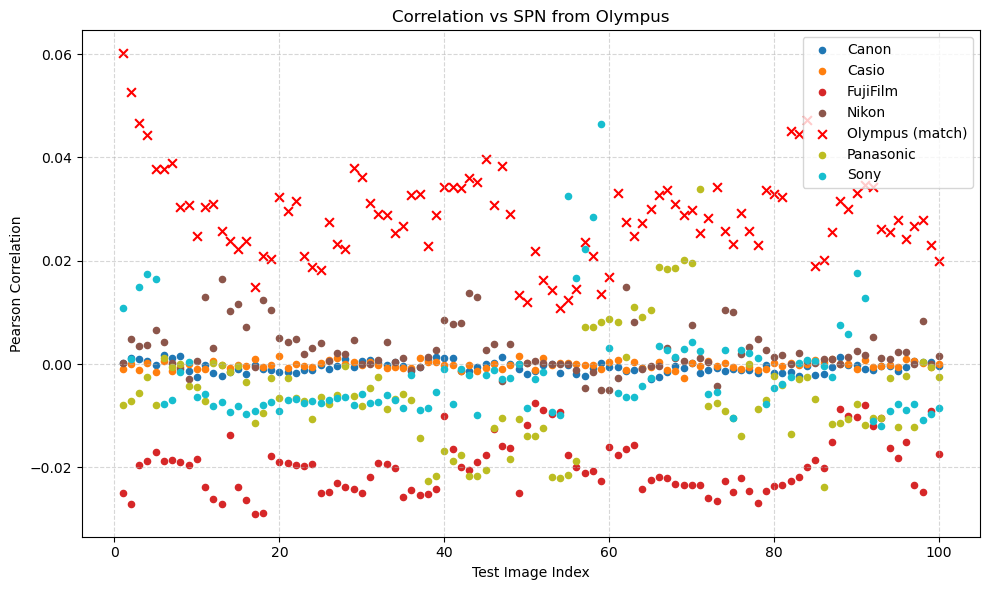

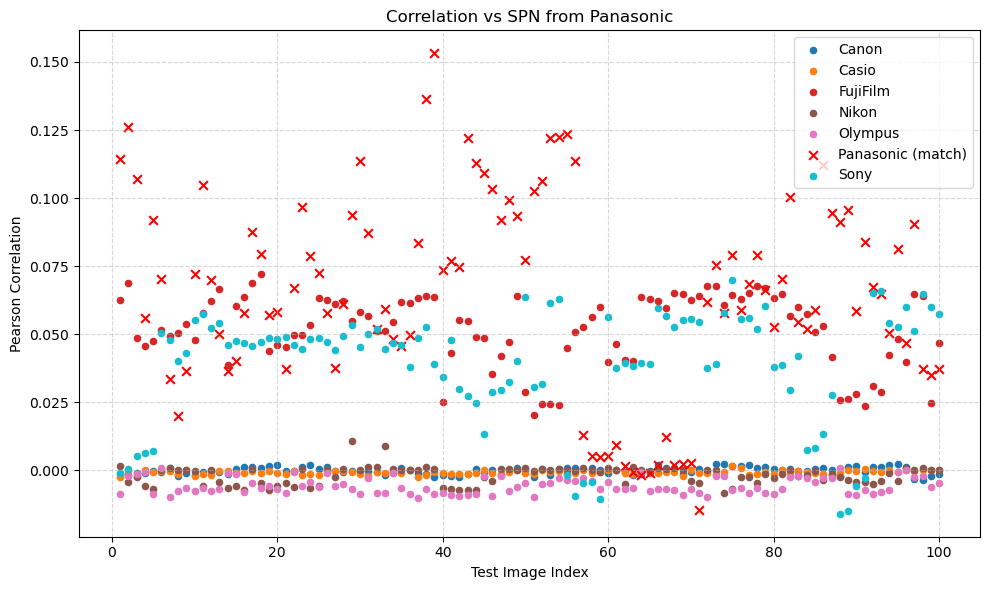

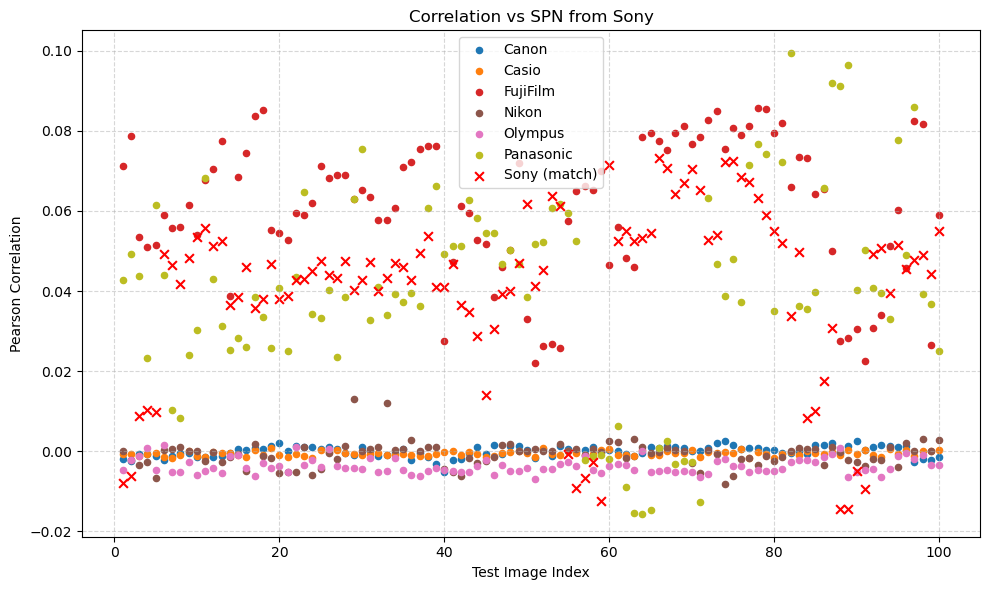

In [ ]:
camera_list = sorted(next(iter(final_dict.values())).keys()) 
colors = cm.get_cmap('tab10', len(camera_list))
for idx, (target_cam, corr_dict) in enumerate(final_dict.items()):
    plt.figure(figsize=(10, 6))
    plt.title(f'Correlation vs SPN from {target_cam}')
    plt.xlabel("Test Image Index")
    plt.ylabel("Pearson Correlation")

    for cam_idx, camera in enumerate(camera_list):
        y = corr_dict[camera]
        x = list(range(1, len(y) + 1))

        if camera == target_cam:
            plt.scatter(x, y, label=f"{camera} (match)", color='red', marker='x', s=40, linewidths=1.5)
        else:
            plt.scatter(x, y, label=camera, color=colors(cam_idx), marker='o', s=20)

    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


## Using another method (BEST RESULTS)
This method is mentioned in the paper : 

This method is pretty much similar to the method mentioned in the given paper but the only edge is that this paper suggested using something called ```spectrum eualization()```

more details in the report.

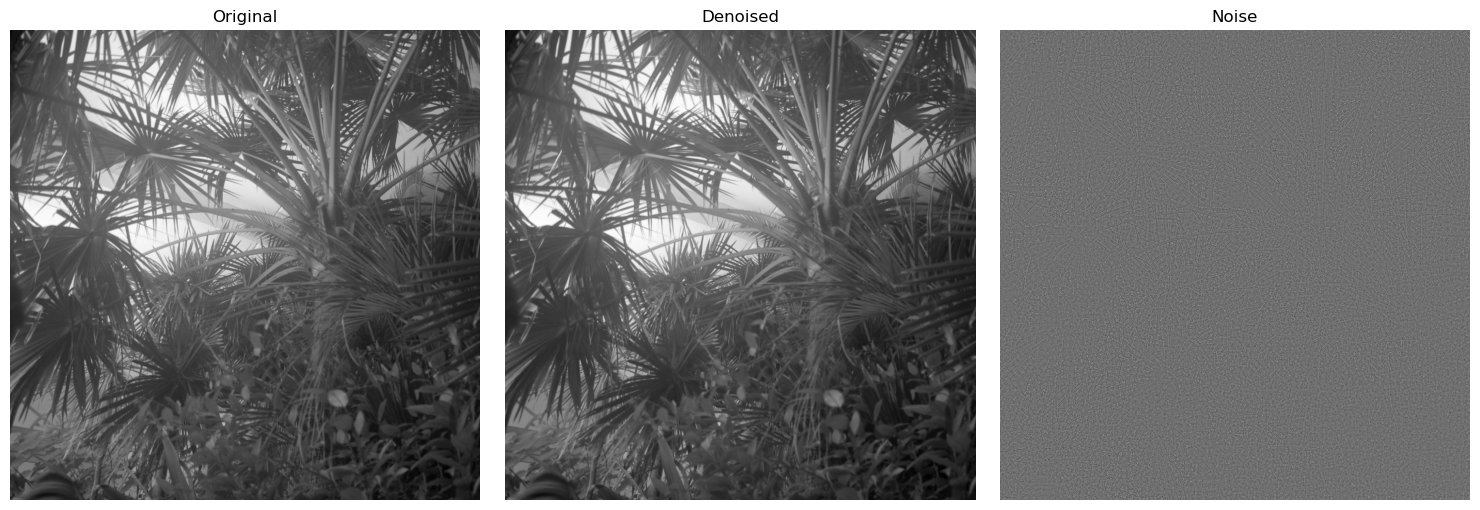

In [68]:
def adaptive_wavelet_denoise(image, wavelet='sym8', level=4):
    try:
        image = image.astype(np.float32)
        min_dim = min(image.shape)
        max_level = int(np.log2(min_dim)) - 1
        level = min(level, max_level) if max_level > 0 else 1
        
        coeffs = pywt.wavedec2(image, wavelet, level=level)
        cA = coeffs[0]
        details = coeffs[1:]
        
        flattened_details = []
        for detail in details:
            for c in detail:
                if c.size > 0:  
                    flattened_details.append(c.ravel())
        if not flattened_details:
            raise ValueError("No valid detail coefficients for sigma estimation")
        flattened_details = np.concatenate(flattened_details)
        
        sigma = np.median(np.abs(flattened_details)) / 0.6745
        threshold = sigma * np.sqrt(2 * np.log(image.size))
        
        denoised_coeffs = [cA]
        for detail in details:
            denoised_detail = tuple(pywt.threshold(c, threshold, mode='soft') for c in detail)
            denoised_coeffs.append(denoised_detail)
        
        denoised = pywt.waverec2(denoised_coeffs, wavelet)
        denoised = denoised[:image.shape[0], :image.shape[1]]
        return denoised
    except Exception as e:
        raise ValueError(f"Wavelet denoising failed: {e}")

def spectrum_equalization(noise, block_size=64):
    h, w = noise.shape
    equalized_noise = noise.copy()
    
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = noise[i:i+block_size, j:j+block_size]
            if block.shape[0] < block_size or block.shape[1] < block_size:
                continue
            fft_block = fftpack.fft2(block)
            mag_spectrum = np.abs(fft_block)
            threshold = np.percentile(mag_spectrum, 99)
            mask = mag_spectrum > threshold
            fft_block[mask] *= 0.5
            block_equalized = np.real(fftpack.ifft2(fft_block))
            equalized_noise[i:i+block_size, j:j+block_size] = block_equalized
    
    return equalized_noise

def extract_noise(image_cropped):
    denoised = adaptive_wavelet_denoise(image_cropped)
    noise = image_cropped - denoised
    noise = spectrum_equalization(noise)
    return noise

path = 'DIP Data/Nikon_D70/Nikon_D70_0_19535.JPG'
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
image = image[:y, :x]
noise = extract_noise(image)
denoised_image = image - noise

plt.figure(figsize=(15, 5))
    
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title(f'Original')
plt.axis('off')

plt.subplot(132)
plt.imshow(denoised_image, cmap='gray')
plt.title(f'Denoised')
plt.axis('off')

plt.subplot(133)
plt.imshow(noise, cmap='gray')
plt.title(f'Noise')
plt.axis('off')

plt.tight_layout()
plt.show()


In [86]:
def extract_noise(image_cropped):
    denoised = adaptive_wavelet_denoise(image_cropped)
    noise = image_cropped - denoised
    noise = spectrum_equalization(noise)
    return noise

In [87]:
save_noise(input_path, filename="noise_data.h5", compression="gzip")

300


Processing Canon_Ixus70_0:   0%|          | 0/300 [00:00<?, ?it/s]

Processing Canon_Ixus70_0: 100%|██████████| 300/300 [02:45<00:00,  1.81it/s]


300


Processing Casio_EX_Z150_0: 100%|██████████| 300/300 [04:59<00:00,  1.00it/s]


300


Processing FujiFilm_FinePixJ50_0: 100%|██████████| 300/300 [05:32<00:00,  1.11s/it]


300


Processing Nikon_D70: 100%|██████████| 300/300 [02:34<00:00,  1.95it/s]


300


Processing Olympus_mju_1050SW: 100%|██████████| 300/300 [07:37<00:00,  1.52s/it]


300


Processing Panasonic_DMC_FZ50: 100%|██████████| 300/300 [08:38<00:00,  1.73s/it]


300


Processing Sony_DSC_W170: 100%|██████████| 300/300 [05:29<00:00,  1.10s/it]

Saved noise arrays to noise_data.h5


In [ ]:
target_noises = target_noise(100)
target_noises

In [38]:
final_dict = compute_correlations(target_noises)


Calculating correlation for target: Canon


Processing Sony: 100%|██████████| 100/100 [00:07<00:00, 14.01it/s]



Calculating correlation for target: Casio


Processing Sony: 100%|██████████| 100/100 [00:06<00:00, 16.42it/s]



Calculating correlation for target: FujiFilm


Processing Sony: 100%|██████████| 100/100 [00:07<00:00, 14.19it/s]



Calculating correlation for target: Nikon


Processing Sony: 100%|██████████| 100/100 [00:05<00:00, 17.52it/s]



Calculating correlation for target: Olympus


Processing Sony: 100%|██████████| 100/100 [00:06<00:00, 14.66it/s]



Calculating correlation for target: Panasonic


Processing Sony: 100%|██████████| 100/100 [00:07<00:00, 13.87it/s]



Calculating correlation for target: Sony


Processing Sony: 100%|██████████| 100/100 [00:06<00:00, 15.70it/s]

Correlation computation completed


/tmp/ipykernel_584151/451534584.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(camera_list))  # Unique color per camera


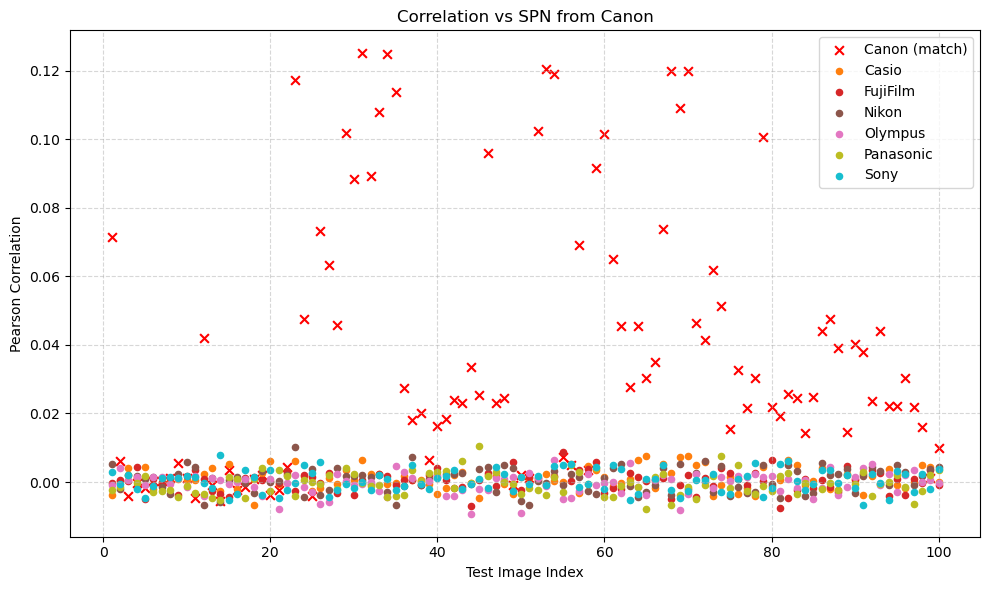

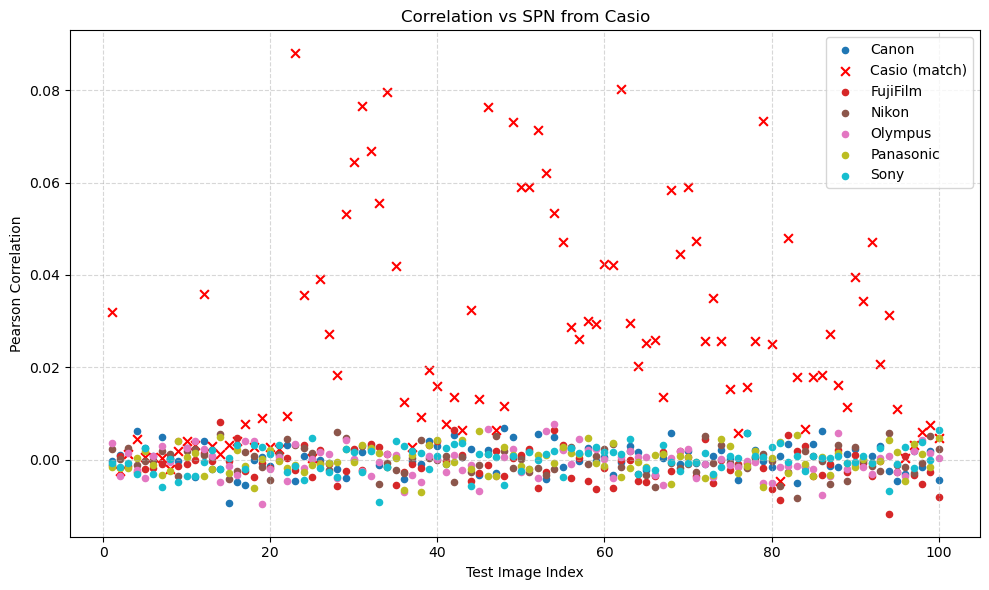

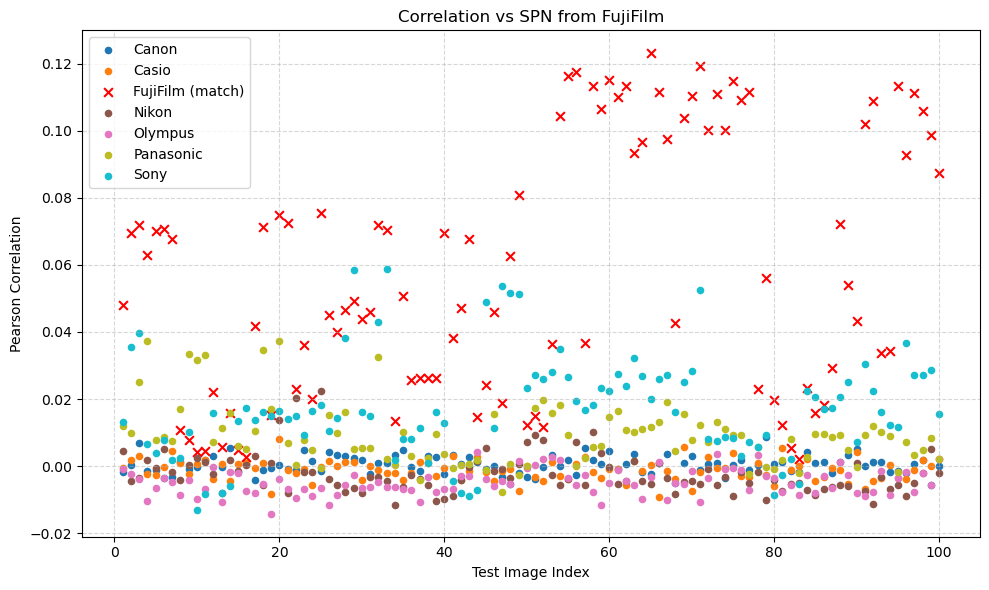

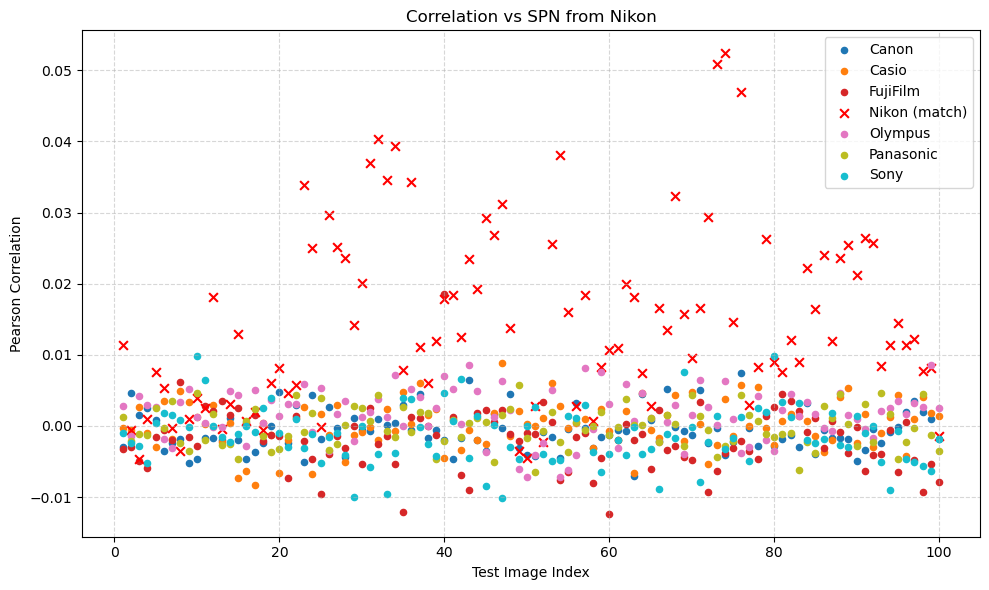

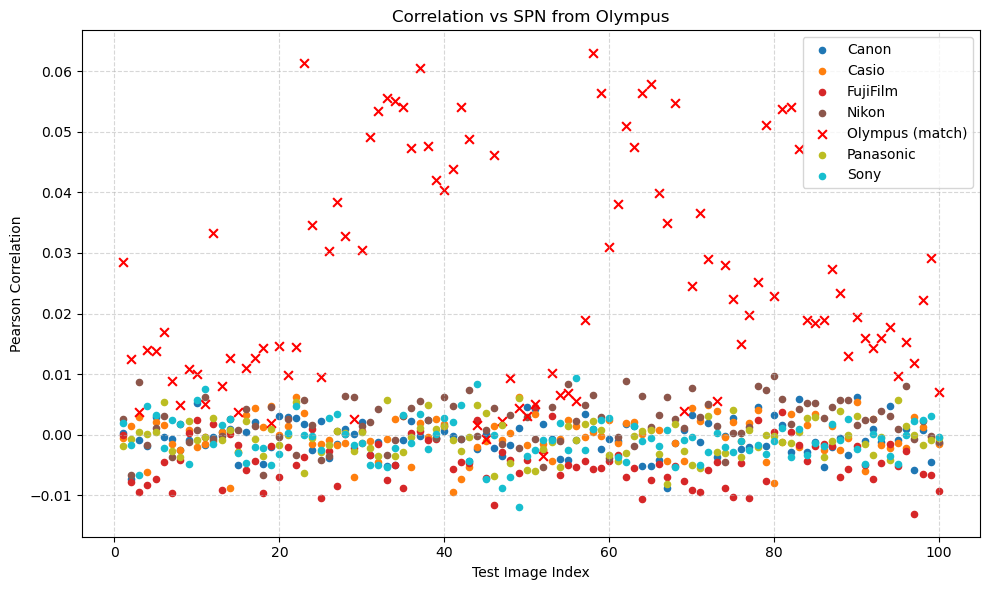

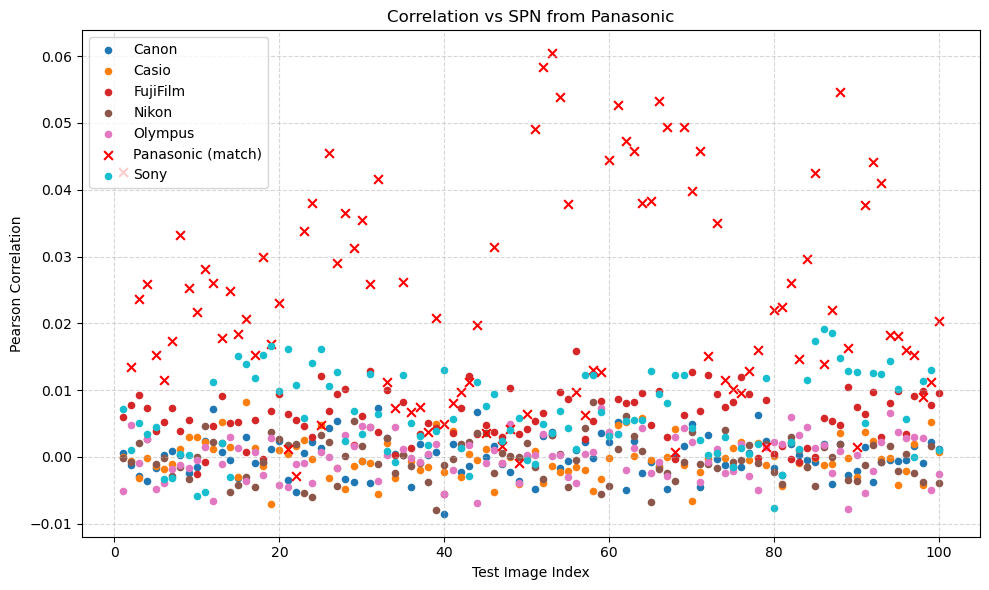

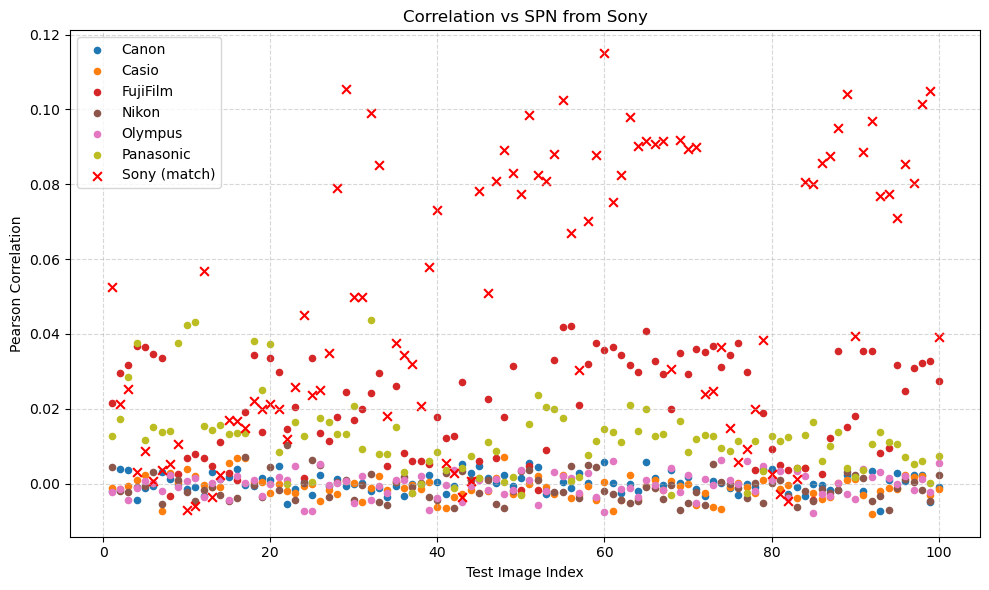

In [ ]:
camera_list = sorted(next(iter(final_dict.values())).keys()) 
colors = cm.get_cmap('tab10', len(camera_list))
for idx, (target_cam, corr_dict) in enumerate(final_dict.items()):
    plt.figure(figsize=(10, 6))
    plt.title(f'Correlation vs SPN from {target_cam}')
    plt.xlabel("Test Image Index")
    plt.ylabel("Pearson Correlation")

    for cam_idx, camera in enumerate(camera_list):
        y = corr_dict[camera]
        x = list(range(1, len(y) + 1))

        if camera == target_cam:
            plt.scatter(x, y, label=f"{camera} (match)", color='red', marker='x', s=40, linewidths=1.5)
        else:
            plt.scatter(x, y, label=camera, color=colors(cam_idx), marker='o', s=20)

    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

## Analysis on Malacious images (Images with removed noise)

Third method is used to extract noise from denoised images and stored in the ```denoised_noise_data.h5```

The results does not consides with the one shown in the paper.

In [ ]:
def save_denoised(input_path, filename, compression="gzip"):
    with h5py.File(filename, "w") as f:
        for folder in os.listdir(input_path):
            folder_path = os.path.join(input_path, folder)
            if not os.path.isdir(folder_path):
                continue
            f_name = folder.split('_')[0]  # Extract brand (e.g., 'Canon' from 'Canon_001')
            image_files = sorted([f for f in os.listdir(folder_path)])
            
            # Create group for brand
            group = f.create_group(f_name)
            print(len(image_files))
            # Process each image
            for idx, img_file in enumerate(tqdm(image_files[200:], desc=f"Processing {folder}"), 1):
                img_path = os.path.join(folder_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                cropped = img[:512, :512]
                denoised = adaptive_wavelet_denoise(cropped)
                noise = extract_noise(denoised)
                if noise is None:
                    continue
                group.create_dataset(f"array_{idx}", data=noise, compression=compression)
    
    print(f"Saved noise arrays to {filename}")
 
save_denoised(input_path, filename="denoised_noise_data.h5", compression="gzip")

300


Processing Canon_Ixus70_0: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


300


Processing Casio_EX_Z150_0: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


300


Processing FujiFilm_FinePixJ50_0: 100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


300


Processing Nikon_D70: 100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


300


Processing Olympus_mju_1050SW: 100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


300


Processing Panasonic_DMC_FZ50: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


300


Processing Sony_DSC_W170: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]

Saved noise arrays to denoised_noise_data.h5


In [ ]:
def compute_correlations(target_noises, hdf5_file="denoised_noise_data.h5"):
    final_dict = {}
    with h5py.File(hdf5_file, "r") as f:
        for target, target_spn in target_noises.items():
            # Result dictionary for this target
            correlation_dict = {}
            print(f"\nCalculating correlation for target: {target}")
            
            # Loop through all brands in HDF5
            for camera_dir in f.keys():
                correlation_dict[camera_dir] = []
                group = f[camera_dir]
                # Get all array keys, sorted
                array_keys = sorted(group.keys())
            
                for key in tqdm(array_keys, desc=f"Processing {camera_dir}"):
                    try:
                        noise = group[key][:]  # Load noise array (2000x2000, float32)
                        corr = pearson_correlation(noise, target_spn)
                        correlation_dict[camera_dir].append(corr)
                    except KeyError:
                        print(f"Error: Could not find {key} in {camera_dir}. Skipping.")
                        continue
                
                if not correlation_dict[camera_dir]:
                    print(f"Warning: No correlations computed for {camera_dir}.")
            
            final_dict[target] = correlation_dict
    
    print("Correlation computation completed")
    return final_dict

final_dict = compute_correlations(target_noises)


Calculating correlation for target: Canon


Processing Sony: 100%|██████████| 100/100 [00:04<00:00, 22.51it/s]



Calculating correlation for target: Casio


Processing Sony: 100%|██████████| 100/100 [00:06<00:00, 16.16it/s]



Calculating correlation for target: FujiFilm


Processing Sony: 100%|██████████| 100/100 [00:06<00:00, 15.84it/s]



Calculating correlation for target: Nikon


Processing Sony: 100%|██████████| 100/100 [00:06<00:00, 15.67it/s]



Calculating correlation for target: Olympus


Processing Sony: 100%|██████████| 100/100 [00:05<00:00, 18.04it/s]



Calculating correlation for target: Panasonic


Processing Sony: 100%|██████████| 100/100 [00:05<00:00, 17.15it/s]



Calculating correlation for target: Sony


Processing Sony: 100%|██████████| 100/100 [00:04<00:00, 21.06it/s]

Correlation computation completed


/tmp/ipykernel_584151/3301961523.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(camera_list))  # Unique color per camera


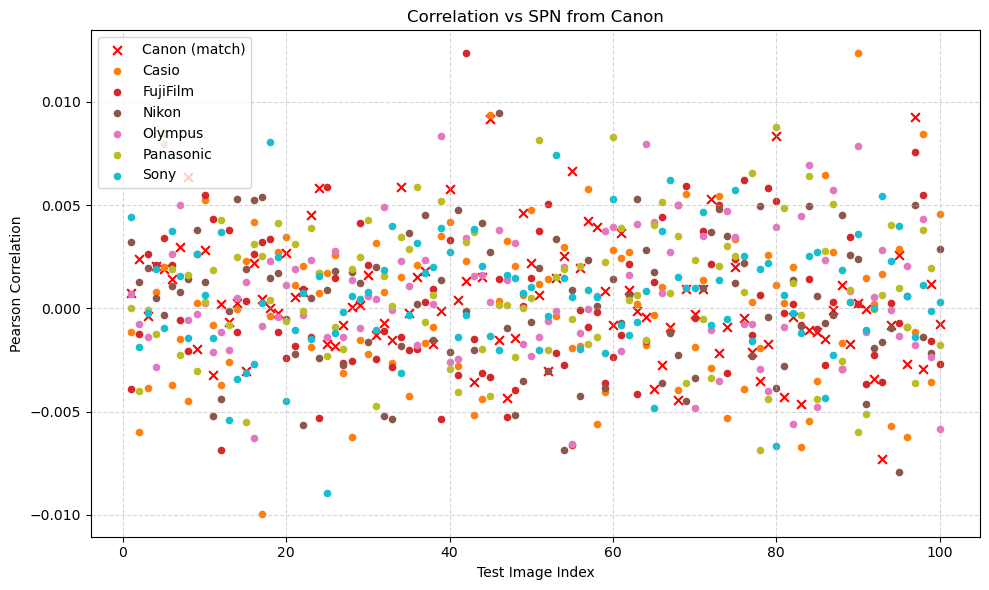

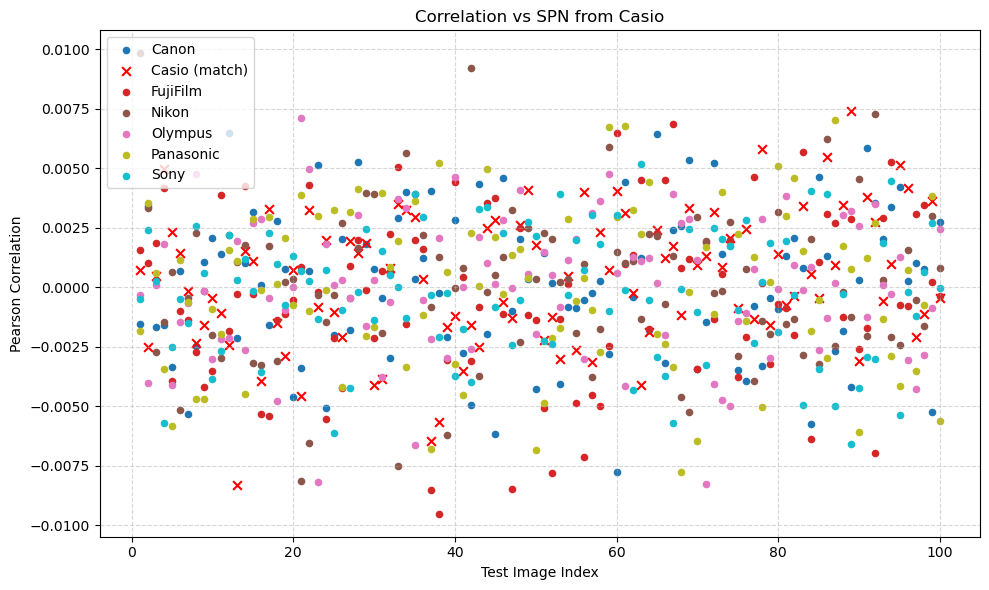

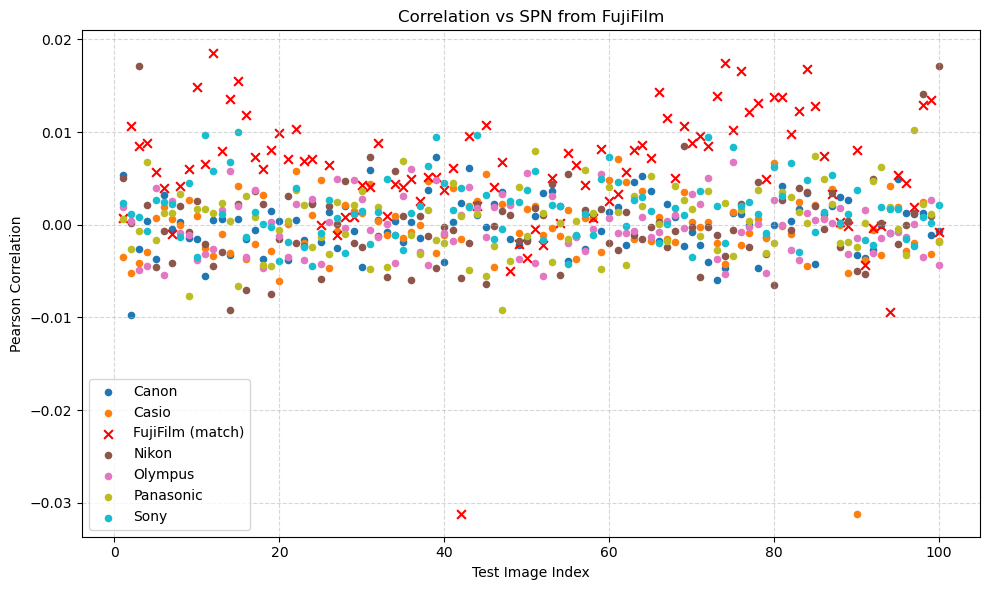

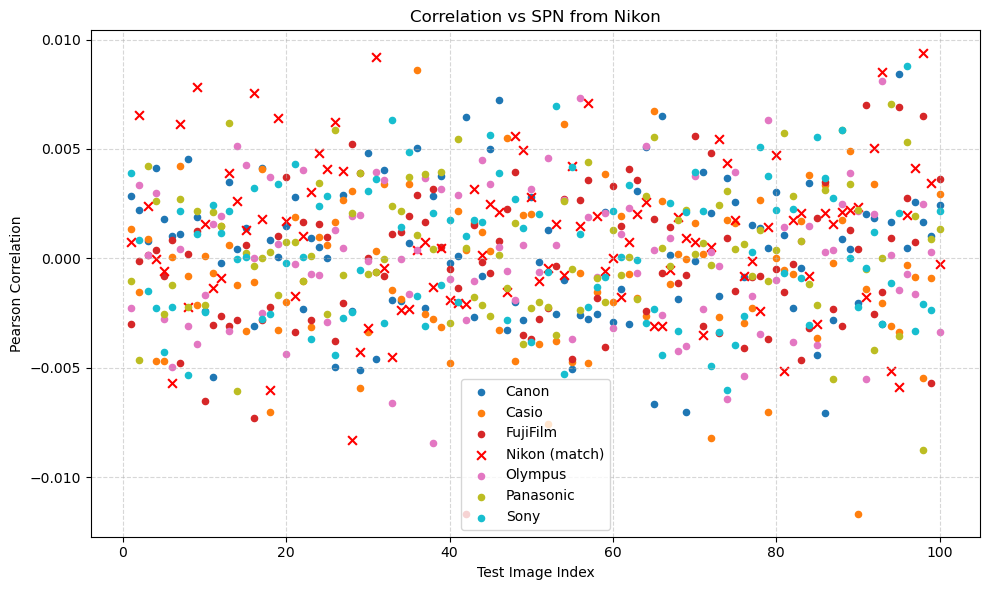

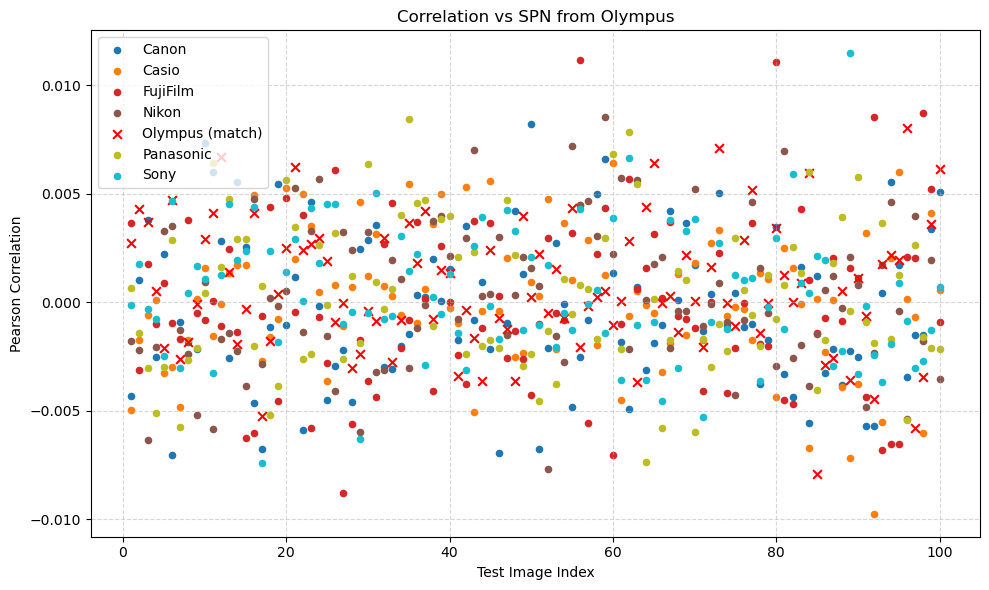

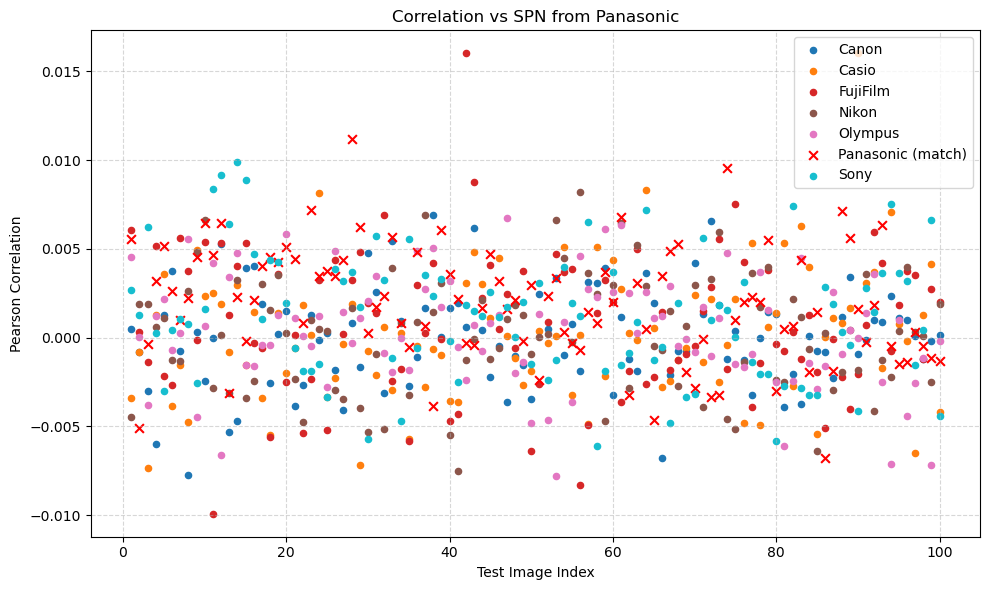

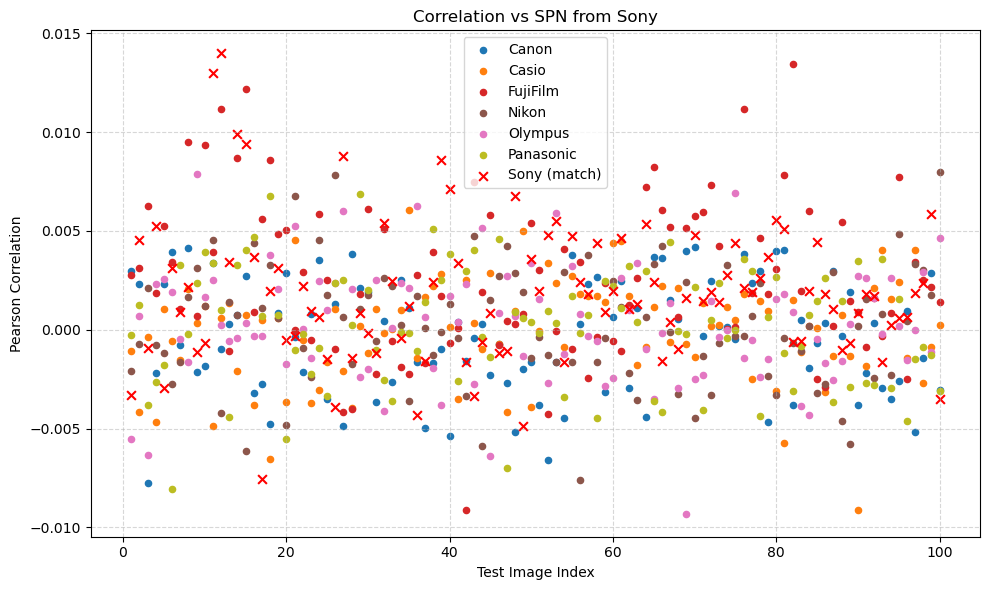

In [ ]:
camera_list = sorted(next(iter(final_dict.values())).keys()) 
colors = cm.get_cmap('tab10', len(camera_list))
for idx, (target_cam, corr_dict) in enumerate(final_dict.items()):
    plt.figure(figsize=(10, 6))
    plt.title(f'Correlation vs SPN from {target_cam}')
    plt.xlabel("Test Image Index")
    plt.ylabel("Pearson Correlation")

    for cam_idx, camera in enumerate(camera_list):
        y = corr_dict[camera]
        x = list(range(1, len(y) + 1))

        if camera == target_cam:
            plt.scatter(x, y, label=f"{camera} (match)", color='red', marker='x', s=40, linewidths=1.5)
        else:
            plt.scatter(x, y, label=camera, color=colors(cam_idx), marker='o', s=20)

    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


## Avg Correlation vs Sample size

In [44]:
def compute_target_noise_and_correlation(hdf5_file="noise_data.h5", max_noises=250):
    result_dict = {}
    
    with h5py.File(hdf5_file, "r") as f:
        # Get all brands and select specified indices
        all_brands = sorted(f.keys())
        selected_brands = all_brands[:4]
        print(f"Selected brands: {selected_brands}")
        
        for brand in selected_brands:
            print(f"\nProcessing brand: {brand}")
            group = f[brand]
            array_keys = sorted(group.keys())
            
            # Initialize results for this brand
            avg_correlations = []
            
            # Compute target noise for 1 to max_noises
            noise_accumulator = None
            for n in tqdm(range(1, max_noises + 1), desc=f"Computing target noise for {brand}"):
                try:
                    noise = group[array_keys[n - 1]][:]  # Load nth array (0-based index)
                    if noise_accumulator is None:
                        noise_accumulator = np.zeros_like(noise, dtype=np.float64)
                    noise_accumulator += noise
                    target_spn = (noise_accumulator / n).astype(np.float64)
                    
                    # Compute correlations with last 50 noises (indices 250 to 299)
                    correlations = []
                    for key in array_keys[250:]:  # Last 50 (250 to 299)
                        noise = group[key][:]  # Load noise array
                        corr = pearson_correlation(noise, target_spn)
                        correlations.append(corr)
                        
                    # Compute average correlation
                    if correlations:
                        avg_corr = np.mean(correlations)
                        avg_correlations.append(avg_corr)
                    else:
                        print(f"Warning: No correlations computed for {brand} with {n} noises.")
                        avg_correlations.append(0.0)
                
                except KeyError:
                    print(f"Error: Could not find {array_keys[n - 1]} in {brand}. Skipping.")
                    avg_correlations.append(0.0)
                    continue
            
            result_dict[brand] = avg_correlations
            print(f"Completed {brand}: {len(avg_correlations)} average correlations computed")
    
    print("Processing completed")
    return result_dict

result_dict = compute_target_noise_and_correlation()

Selected brands: ['Canon', 'Casio', 'FujiFilm', 'Nikon']

Processing brand: Canon


Computing target noise for Canon: 100%|██████████| 250/250 [11:19<00:00,  2.72s/it]


Completed Canon: 250 average correlations computed

Processing brand: Casio


Computing target noise for Casio: 100%|██████████| 250/250 [12:19<00:00,  2.96s/it]


Completed Casio: 250 average correlations computed

Processing brand: FujiFilm


Computing target noise for FujiFilm: 100%|██████████| 250/250 [12:04<00:00,  2.90s/it]


Completed FujiFilm: 250 average correlations computed

Processing brand: Nikon


Computing target noise for Nikon: 100%|██████████| 250/250 [10:08<00:00,  2.43s/it]

Completed Nikon: 250 average correlations computed
Processing completed


/tmp/ipykernel_584151/2489963619.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(camera_list))


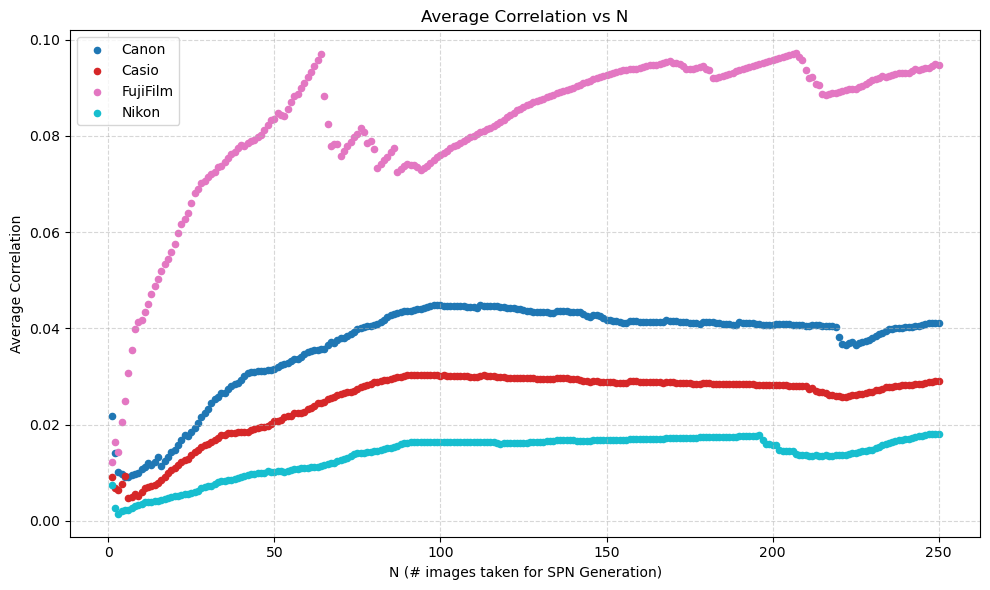

In [45]:
camera_list = result_dict.keys()
colors = cm.get_cmap('tab10', len(camera_list))

plt.figure(figsize=(10, 6))
plt.title('Average Correlation vs N')
plt.xlabel("N (# images taken for SPN Generation)")
plt.ylabel("Average Correlation")

for cam_idx, camera in enumerate(camera_list):
    y = result_dict[camera]
    x = list(range(1, len(y) + 1))
    plt.scatter(x, y, label=camera, color=colors(cam_idx), marker='o', s=20)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Compute Accuracy

Best accuracy is obtained by the Cameras are as follows:
- Canon_Ixus70_0 :         $\hspace{0.5in}$ 81%
- Casio_EX_Z150_0 :       $\hspace{0.45in}$ 83%
- FujiFilm_FinePixJ50_0 : $\hspace{0.25in}$ 94%
- Nikon_D70 :             $\hspace{0.75in}$ 76%
- Olympus_mju_1050SW :    $\hspace{0.15in}$ 89%
- Panasonic_DMC_FZ50 :     $\hspace{0.2in}$ 77%
- Sony_DSC_W170 :         $\hspace{0.45in}$ 82%

In [90]:
accuracy = compute_accuracy(target_noises)

Brands: ['Canon', 'Casio', 'FujiFilm', 'Nikon', 'Olympus', 'Panasonic', 'Sony']
100

Processing test arrays for Canon


Testing Canon: 100%|██████████| 100/100 [00:06<00:00, 15.16it/s]


Canon: 81/100 correct, Accuracy = 81.0000
100

Processing test arrays for Casio


Testing Casio: 100%|██████████| 100/100 [00:07<00:00, 13.25it/s]


Casio: 83/100 correct, Accuracy = 83.0000
100

Processing test arrays for FujiFilm


Testing FujiFilm: 100%|██████████| 100/100 [00:07<00:00, 14.22it/s]


FujiFilm: 94/100 correct, Accuracy = 94.0000
100

Processing test arrays for Nikon


Testing Nikon: 100%|██████████| 100/100 [00:07<00:00, 14.22it/s]


Nikon: 76/100 correct, Accuracy = 76.0000
100

Processing test arrays for Olympus


Testing Olympus: 100%|██████████| 100/100 [00:06<00:00, 15.28it/s]


Olympus: 89/100 correct, Accuracy = 89.0000
100

Processing test arrays for Panasonic


Testing Panasonic: 100%|██████████| 100/100 [00:06<00:00, 15.76it/s]


Panasonic: 77/100 correct, Accuracy = 77.0000
100

Processing test arrays for Sony


Testing Sony: 100%|██████████| 100/100 [00:05<00:00, 17.31it/s]

Sony: 82/100 correct, Accuracy = 82.0000
Accuracy computation completed


In [89]:
accuracy

{'Canon': 81,
 'Casio': 83,
 'FujiFilm': 94,
 'Nikon': 76,
 'Olympus': 89,
 'Panasonic': 77,
 'Sony': 82}